## Outline of the Steps

0. General info, read in data and clean for EDA: 
1. Exploratory Data Analysis (EDA): 
2. Split the data into different sets
3. Preprocess the data: 
4. Choose an evaluation metric
5. Choose one or more ML techniques:
6. Tune the hyperparameters of your ML models
7. Interpret your model

### 0.0 General info

Context
Is the movie industry dying? is Netflix the new entertainment king? Those were the first questions that lead me to create a dataset
focused on movie revenue and analyze it over the last decades. But, why stop there? There are more factors that intervene in this
kind of thing, like actors, genres, user ratings and more. And now, anyone with experience (you) can ask specific questions about the
movie industry, and get answers.

budget: the budget of a movie.

company: the production company

country: country of origin

director: the director

genre: main genre of the movie.

gross: revenue of the movie

name: name of the movie

rating: rating of the movie (R, PG, etc.)

released: release date (YYYY-MM-DD)

runtime: duration of the movie

score: IMDb user rating

votes: number of user votes

star: main actor/actress

writer: writer of the movie

year: year of release

Acknowledgements
This data was scraped from IMDb.

Q: Predict the gross based on the rest features.

### 0.1 Read in the data

In [1]:
# neede libraries
import numpy as np
import pandas as pd 
import ast
import wordcloud
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry 
import geopandas
import datetime
from wordcloud import WordCloud
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import pickle

In [2]:
# load data from a csv file
df = pd.read_csv('../data/movies.csv')

### 0.2 clean up the data and make it ready for EDA:

In [3]:
pd.set_option('display.max_columns', 500)
df.head(5)

,Unnamed: 0,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


In [4]:
df = df.drop('Unnamed: 0', 1)

/var/folders/9h/f_x4v9yn501dvc2jkc54t6fw0000gn/T/ipykernel_87095/3812631323.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('Unnamed: 0', 1)


In [5]:
df.shape

(7668, 15)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7668 non-null   object 
 1   rating    7591 non-null   object 
 2   genre     7668 non-null   object 
 3   year      7668 non-null   int64  
 4   released  7666 non-null   object 
 5   score     7665 non-null   float64
 6   votes     7665 non-null   float64
 7   director  7668 non-null   object 
 8   writer    7665 non-null   object 
 9   star      7667 non-null   object 
 10  country   7665 non-null   object 
 11  budget    7668 non-null   float64
 12  gross     7479 non-null   float64
 13  company   7651 non-null   object 
 14  runtime   7664 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 898.7+ KB


In [7]:
df.describe(include='all')

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
count,7668,7591,7668,7668.000000,7666,7665.000000,7.665000e+03,7668,7665,7667,7665,7.668000e+03,7.479000e+03,7651,7664.000000
unique,7512,12,19,NaN,3414,NaN,NaN,2949,4535,2814,59,NaN,NaN,2385,NaN
top,Nobody's Fool,R,Comedy,NaN,"February 14, 1986 (United States)",NaN,NaN,Woody Allen,Woody Allen,Nicolas Cage,United States,NaN,NaN,Universal Pictures,NaN
freq,3,3697,2245,NaN,9,NaN,NaN,38,37,43,5475,NaN,NaN,377,NaN
mean,NaN,NaN,NaN,2000.405451,NaN,6.390411,8.810850e+04,NaN,NaN,NaN,NaN,3.390695e+07,7.850054e+07,NaN,107.261613
std,NaN,NaN,NaN,11.153508,NaN,0.968842,1.633238e+05,NaN,NaN,NaN,NaN,3.621766e+07,1.657251e+08,NaN,18.581247
min,NaN,NaN,NaN,1980.000000,NaN,1.900000,7.000000e+00,NaN,NaN,NaN,NaN,3.000000e+03,3.090000e+02,NaN,55.000000
25%,NaN,NaN,NaN,1991.000000,NaN,5.800000,9.100000e+03,NaN,NaN,NaN,NaN,1.210000e+07,4.532056e+06,NaN,95.000000
50%,NaN,NaN,NaN,2000.000000,NaN,6.500000,3.300000e+04,NaN,NaN,NaN,NaN,2.200000e+07,2.020576e+07,NaN,104.000000
75%,NaN,NaN,NaN,2010.000000,NaN,7.100000,9.300000e+04,NaN,NaN,NaN,NaN,4.429000e+07,7.601669e+07,NaN,116.000000


In [8]:
df.isna().sum()

name          0
rating       77
genre         0
year          0
released      2
score         3
votes         3
director      0
writer        3
star          1
country       3
budget        0
gross       189
company      17
runtime       4
dtype: int64

Since our target value here is gross, but there are missing value in the target variable gross here, so we want to remove the missing values in gross.

In [9]:
df = df.dropna(subset=['gross'])

In [10]:
df.isna().sum()

name         0
rating      54
genre        0
year         0
released     0
score        0
votes        0
director     0
writer       3
star         0
country      1
budget       0
gross        0
company     10
runtime      1
dtype: int64

In [11]:
df["rating"].value_counts()

R            3613
PG-13        2091
PG           1222
Not Rated     259
G             152
Unrated        47
NC-17          23
TV-MA           9
TV-PG           4
X               3
Approved        1
TV-14           1
Name: rating, dtype: int64

In [12]:
df['rating'] = df['rating'].replace(['Not Rated','Unrated'],np.NaN)
df["rating"].value_counts()

R           3613
PG-13       2091
PG          1222
G            152
NC-17         23
TV-MA          9
TV-PG          4
X              3
Approved       1
TV-14          1
Name: rating, dtype: int64

In [13]:
director_o = df["director"].value_counts()[10:].index.tolist()
df['director'] = df['director'].replace(director_o,"director_other")
df["director"].value_counts()

director_other       7225
Woody Allen            38
Clint Eastwood         31
Steven Spielberg       27
Directors              27
Ron Howard             24
Ridley Scott           23
Steven Soderbergh      23
Joel Schumacher        22
Barry Levinson         20
Martin Scorsese        19
Name: director, dtype: int64

In [14]:
director_o = df["writer"].value_counts()[10:].index.tolist()
df['writer'] = df['writer'].replace(director_o,"writer_other")
df["writer"].value_counts()

writer_other           7279
Woody Allen              37
Stephen King             31
John Hughes              25
Luc Besson               25
David Mamet              15
William Shakespeare      15
Joel Coen                13
Pedro Almodóvar          13
Wes Craven               12
Quentin Tarantino        11
Name: writer, dtype: int64

In [15]:
director_o = df["star"].value_counts()[10:].index.tolist()
df['star'] = df['star'].replace(director_o,"star_other")
df["star"].value_counts()

star_other            7125
Nicolas Cage            43
Robert De Niro          41
Tom Hanks               41
Denzel Washington       37
Tom Cruise              34
Bruce Willis            34
Johnny Depp             33
Sylvester Stallone      32
John Travolta           30
Steve Martin            29
Name: star, dtype: int64

In [16]:
director_o = df["company"].value_counts()[10:].index.tolist()
df['company'] = df['company'].replace(director_o,"company_other")
df["company"].value_counts()

company_other                5223
Universal Pictures            376
Warner Bros.                  333
Columbia Pictures             332
Paramount Pictures            319
Twentieth Century Fox         240
New Line Cinema               174
Touchstone Pictures           132
Metro-Goldwyn-Mayer (MGM)     123
Walt Disney Pictures          123
TriStar Pictures               94
Name: company, dtype: int64

In [17]:
director_o = df["country"].value_counts()[15:].index.tolist()
df['country'] = df['country'].replace(director_o,"country_other")
df["country"].value_counts()

United States     5377
United Kingdom     798
France             262
country_other      232
Canada             183
Germany            116
Australia           86
Japan               76
India               59
Italy               57
Spain               44
Ireland             42
Hong Kong           40
China               40
South Korea         35
Denmark             31
Name: country, dtype: int64

In [18]:


df[['released', 'released_country']] = df['released'].str.split("\\(", 1, expand=True)


df['released_time'] = pd.to_datetime(df.released)
df['released_year'] = pd.DatetimeIndex(df['released_time']).year
df['released_month'] = pd.DatetimeIndex(df['released_time']).month
df['released_weekday'] = pd.DatetimeIndex(df['released_time']).dayofweek







# Since the year is duplicate with released_time, released_country is duplicate with country
df = df.drop(columns=['year', 'released_country','released','released_time'])




In [19]:
len(df['released_weekday'])

7479

In [20]:
df['name_length'] = df['name'].str.len()

In [21]:
df1 = df.pop('gross')
df['gross']=df1
df['gross_log'] = np.log10(df['gross'])

In [22]:
df

,name,rating,genre,score,votes,director,writer,star,country,budget,company,runtime,released_year,released_month,released_weekday,name_length,gross,gross_log
0,The Shining,R,Drama,8.4,927000.0,director_other,Stephen King,star_other,United Kingdom,19000000.0,Warner Bros.,146.0,1980,6,4,11,46998772.0,7.672087
1,The Blue Lagoon,R,Adventure,5.8,65000.0,director_other,writer_other,star_other,United States,4500000.0,Columbia Pictures,104.0,1980,7,2,15,58853106.0,7.769769
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,8.7,1200000.0,director_other,writer_other,star_other,United States,18000000.0,company_other,124.0,1980,6,4,46,538375067.0,8.731085
3,Airplane!,PG,Comedy,7.7,221000.0,director_other,writer_other,star_other,United States,3500000.0,Paramount Pictures,88.0,1980,7,2,9,83453539.0,7.921445
4,Caddyshack,R,Comedy,7.3,108000.0,director_other,writer_other,star_other,United States,6000000.0,company_other,98.0,1980,7,4,10,39846344.0,7.600388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7653,The Quarry,R,Crime,5.4,2400.0,director_other,writer_other,star_other,United States,57530000.0,company_other,98.0,2020,4,4,10,3661.0,3.563600
7655,Legend of Deification,TV-PG,Animation,6.6,1300.0,director_other,NaN,star_other,China,57530000.0,company_other,110.0,2020,10,3,21,240663149.0,8.381410
7656,Tulsa,PG-13,Comedy,5.0,294.0,director_other,writer_other,star_other,United States,57530000.0,company_other,120.0,2020,6,2,5,413378.0,5.616347
7657,Leap,NaN,Drama,6.7,903.0,director_other,writer_other,star_other,China,57530000.0,NaN,135.0,2020,9,4,4,25818882.0,7.411937


The target variable is gross which is numerical, so it is regression model.



The text feature: name

The categorical features: rating, genre, director, writer, star, country, company
    
The numerical features: score, votes, budget,runtime

The time variable: released_time	

### 1.0 Exploratory Data Analysis (EDA):

EDA about the name Variable using word cloud

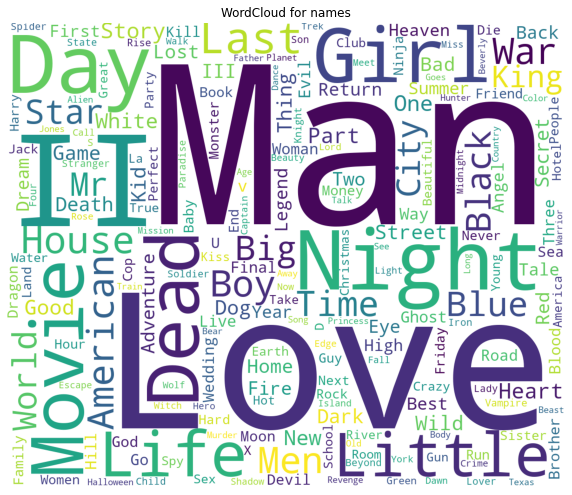

In [23]:
plt.figure(figsize=(10,10))
names=' '.join(df['name'].apply(lambda x:x if x is not np.nan else ''))

wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(names)
plt.imshow(wordcloud)
plt.title('WordCloud for names')
plt.savefig('../figures/WordCloud for names.png',dpi=300)
plt.axis("off")
plt.show()

EDA about the rating and gross

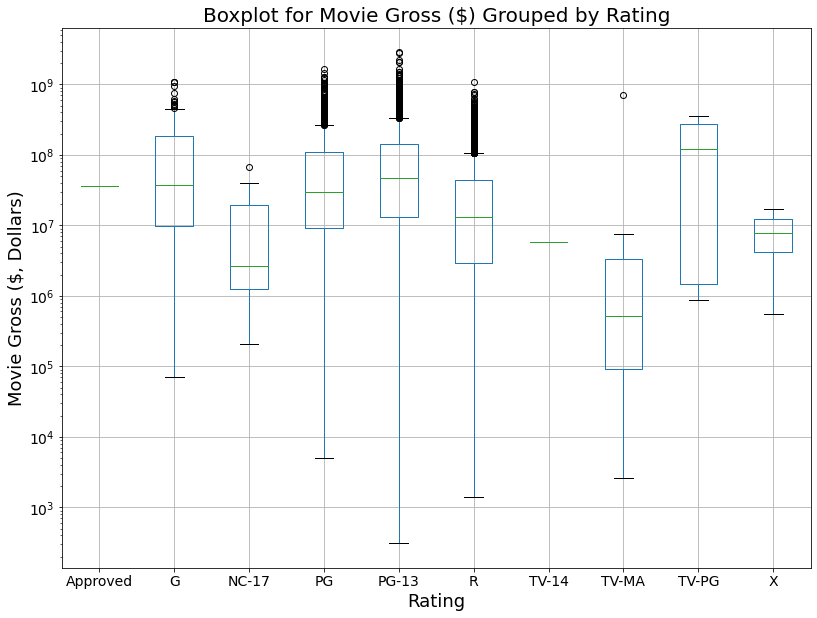

In [24]:
df[['rating','gross']].boxplot(by='rating', grid=True, figsize=(13,10))
plt.title('Boxplot for Movie Gross ($) Grouped by Rating', fontsize=20)
plt.suptitle('')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.yscale('log')
plt.xlabel('Rating',fontsize = 18)
plt.ylabel('Movie Gross ($, Dollars)',fontsize = 18)
plt.savefig('../figures/Boxplot for Gross Grouped by Rating.png',dpi=300)
plt.show()

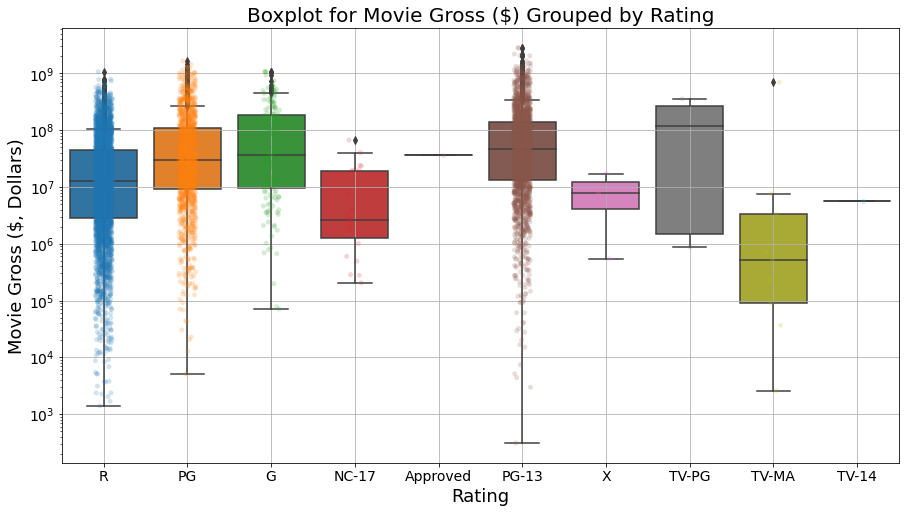

In [25]:
# Better plot for presentation using seaborn
plt.figure(figsize = (15,8))
sns.boxplot(x = "rating",
            y = "gross",
            data = df)
sns.stripplot(x = "rating",
            y = "gross",
            alpha = 0.2,
            data = df)
plt.grid()
plt.yscale('log')
plt.title('Boxplot for Movie Gross ($) Grouped by Rating', fontsize=20)
plt.suptitle('')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xlabel('Rating',fontsize = 18)
plt.ylabel('Movie Gross ($, Dollars)',fontsize = 18)
plt.savefig('../figures/Boxplot for Gross Grouped by Rating_present.png',dpi=300)
plt.show()

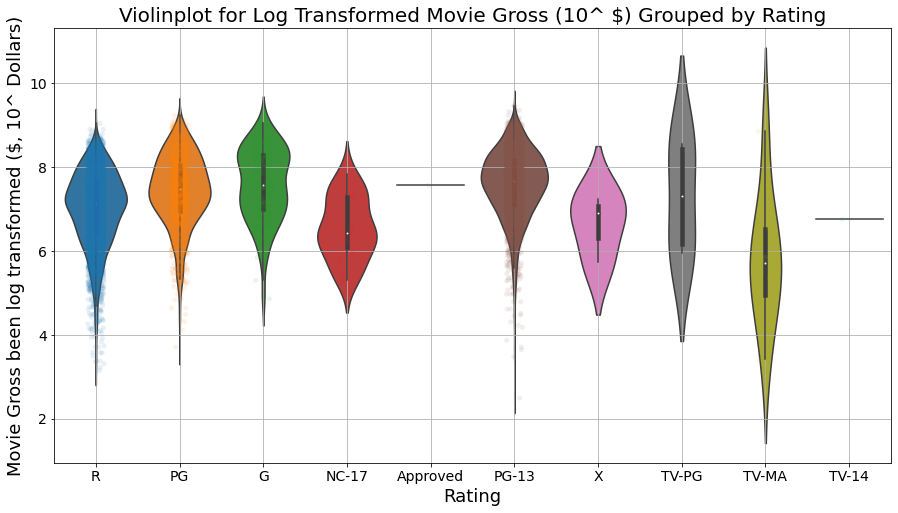

In [26]:




# Better plot for presentation using seaborn

plt.figure(figsize = (15,8))
sns.violinplot(x="rating", y="gross_log", data=df)
sns.stripplot(x = "rating",
            y = "gross_log",
            alpha = 0.1,
            data = df)
plt.grid()
plt.title('Violinplot for Log Transformed Movie Gross (10^ $) Grouped by Rating', fontsize=20)
plt.suptitle('')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xlabel('Rating',fontsize = 18)
plt.ylabel('Movie Gross been log transformed ($, 10^ Dollars)',fontsize = 18)
plt.savefig('../figures/Violin plot for Gross Grouped by Rating_present.png',dpi=300)
plt.show()

EDA about the genre and gross

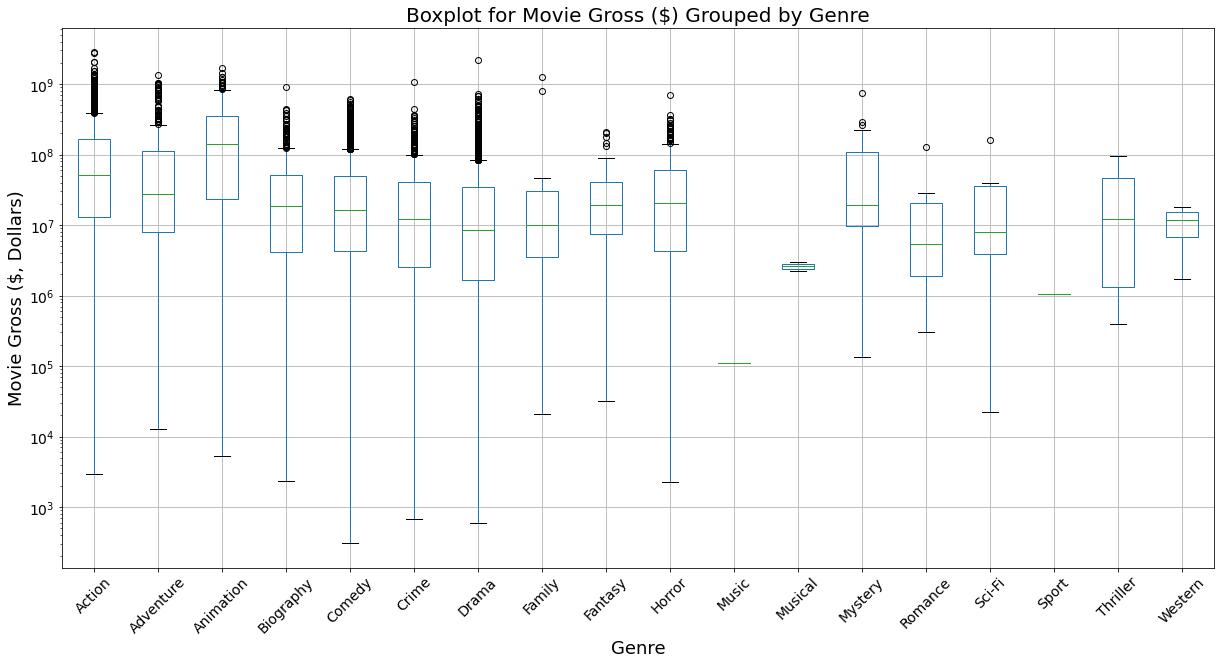

In [27]:
df[['genre','gross']].boxplot(by='genre', grid=True, figsize=(20,10))
plt.title('Boxplot for Movie Gross ($) Grouped by Genre', fontsize=20)
plt.suptitle('')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xticks(rotation=45)
plt.yscale('log')
plt.xlabel('Genre',fontsize = 18)
plt.ylabel('Movie Gross ($, Dollars)',fontsize = 18)
plt.savefig('../figures/Boxplot for Gross Grouped by Genre.png',dpi=300)
plt.show()

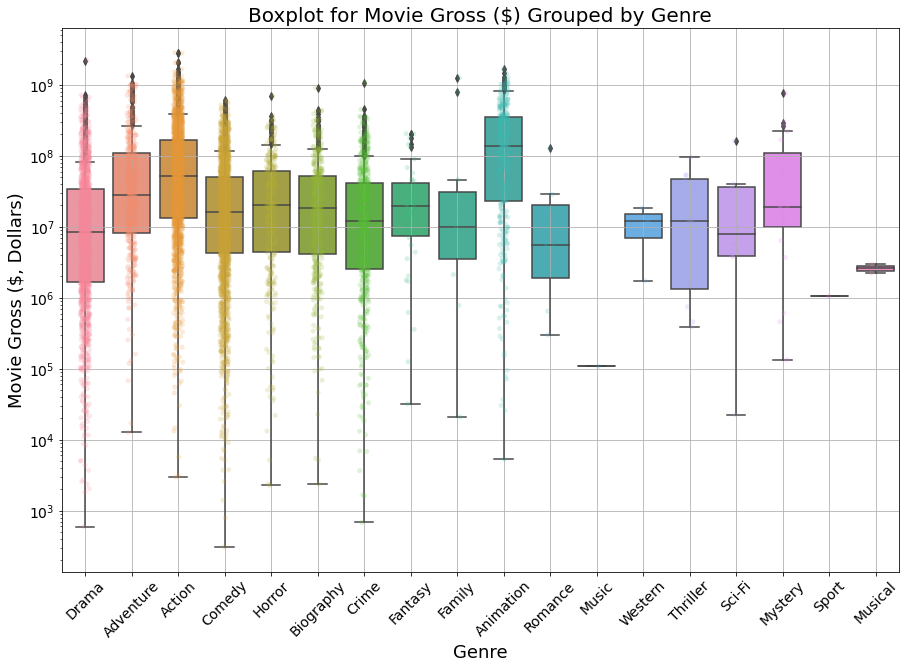

In [28]:
# Better plot for presentation using seaborn
plt.figure(figsize = (15,10))
sns.boxplot(x = "genre",
            y = "gross",
            data = df)
sns.stripplot(x = "genre",
            y = "gross",
            alpha = 0.2,
            data = df)
plt.grid()
plt.yscale('log')
plt.title('Boxplot for Movie Gross ($) Grouped by Genre', fontsize=20)
plt.suptitle('')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xticks(rotation=45)
plt.xlabel('Genre',fontsize = 18)
plt.ylabel('Movie Gross ($, Dollars)',fontsize = 18)
plt.savefig('../figures/Boxplot for Gross Grouped by Genre_present.png',dpi=300)
plt.show()

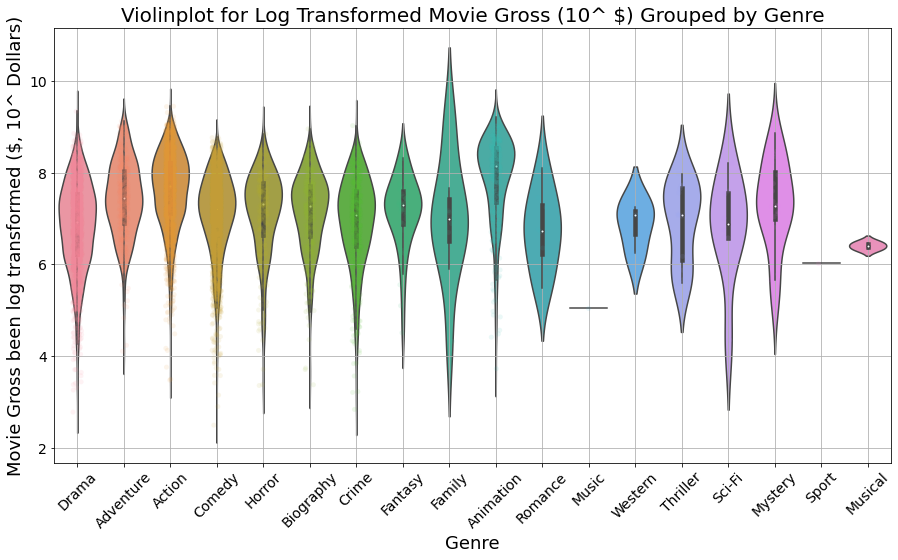

In [29]:
# Better plot for presentation using seaborn

plt.figure(figsize = (15,8))
sns.violinplot(x="genre", y="gross_log", data=df, scale = 'width')
sns.stripplot(x = "genre",
            y = "gross_log",
            alpha = 0.1,
            data = df)
plt.grid()
plt.title('Violinplot for Log Transformed Movie Gross (10^ $) Grouped by Genre', fontsize=20)
plt.suptitle('')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xticks(rotation=45)
plt.xlabel('Genre',fontsize = 18)
plt.ylabel('Movie Gross been log transformed ($, 10^ Dollars)',fontsize = 18)
plt.savefig('../figures/Violin plot for Gross Grouped by Genre_present.png',dpi=300)
plt.show()

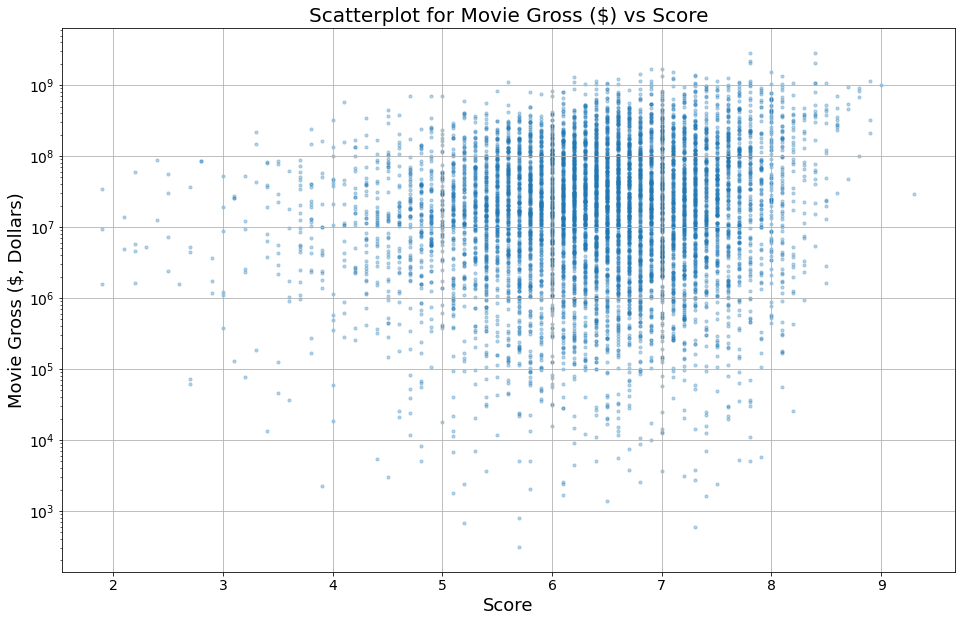

In [30]:
df.plot.scatter('score', 'gross', alpha=0.3, s=10, grid=True, figsize=(16,10))
plt.title('Scatterplot for Movie Gross ($) vs Score', fontsize=20)
plt.yscale('log')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xlabel('Score',fontsize = 18)
plt.ylabel('Movie Gross ($, Dollars)',fontsize = 18)
plt.savefig('../figures/Scatterplot for Movie Gross ($) vs Score.png',dpi=300)
plt.show()


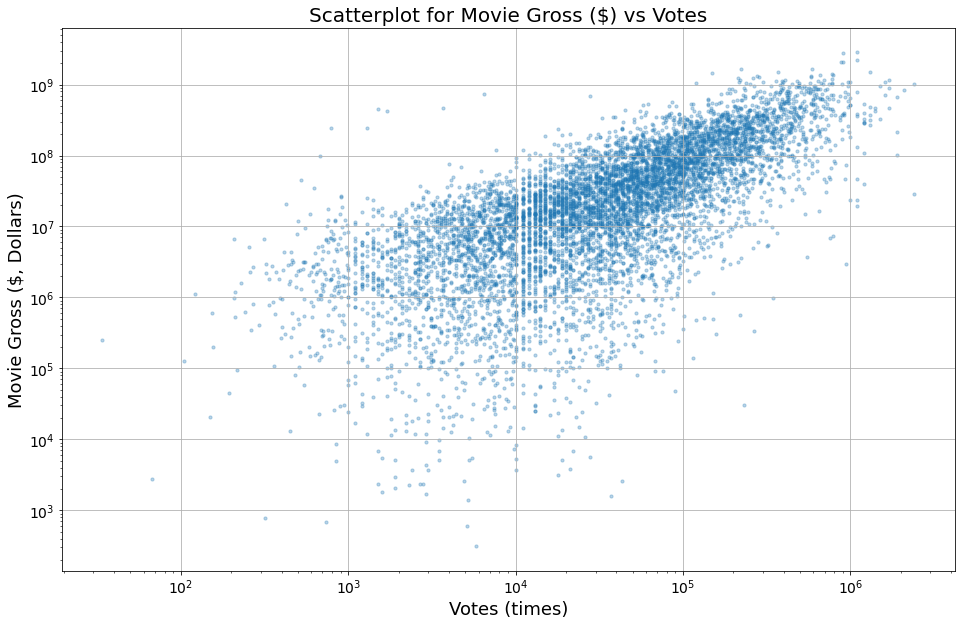

In [31]:
df.plot.scatter('votes', 'gross', alpha=0.3, s=10, grid=True, figsize=(16,10))
plt.title('Scatterplot for Movie Gross ($) vs Votes', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xlabel('Votes (times)',fontsize = 18)
plt.ylabel('Movie Gross ($, Dollars)',fontsize = 18)
plt.savefig('../figures/Scatterplot for Gross vs Votes.png',dpi=300)
plt.show()

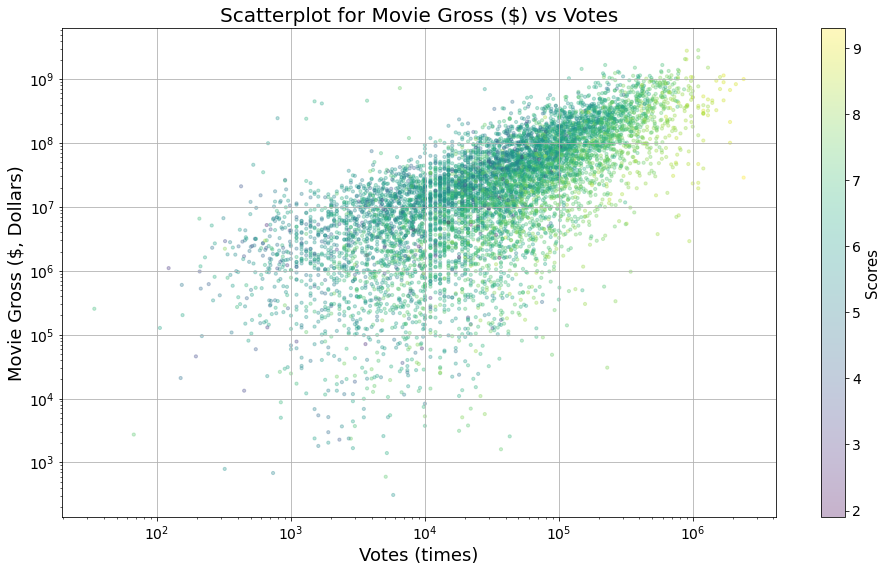

In [32]:
# Better plot for presentation using seaborn

plt.figure(figsize = (16,9))
plt.scatter(df.votes, df.gross, c=df.score, alpha=0.3, s=10, cmap="viridis")
plt.title('Scatterplot for Movie Gross ($) vs Votes', fontsize=20)

cbar = plt.colorbar(label="Scores")
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('Scores',fontsize=15)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xlabel('Votes (times)', fontsize=18)
plt.ylabel('Movie Gross ($, Dollars)', fontsize=18)
plt.grid(True)

plt.xscale('log')
plt.yscale('log')

plt.savefig('../figures/Scatterplot for Gross vs Votes_present.png',dpi=300)
plt.show()


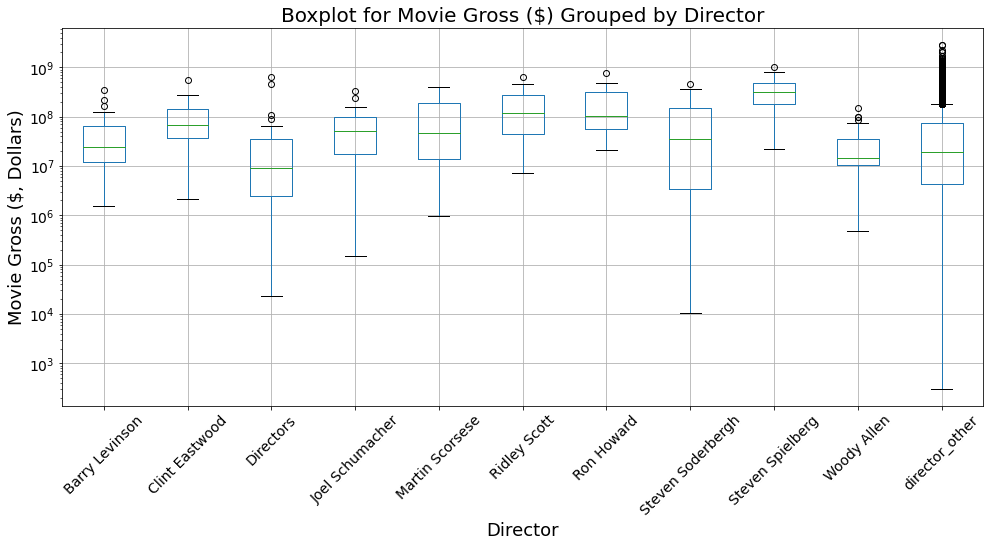

In [33]:
df[['director','gross']].boxplot(by='director', grid=True, figsize=(16,7))
plt.title('Boxplot for Movie Gross ($) Grouped by Director', fontsize=20)
plt.suptitle('')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xticks(rotation=45)
plt.yscale('log')
plt.xlabel('Director',fontsize = 18)
plt.ylabel('Movie Gross ($, Dollars)',fontsize = 18)
plt.savefig('../figures/Boxplot for Gross Grouped by Director.png',dpi=300)
plt.show()

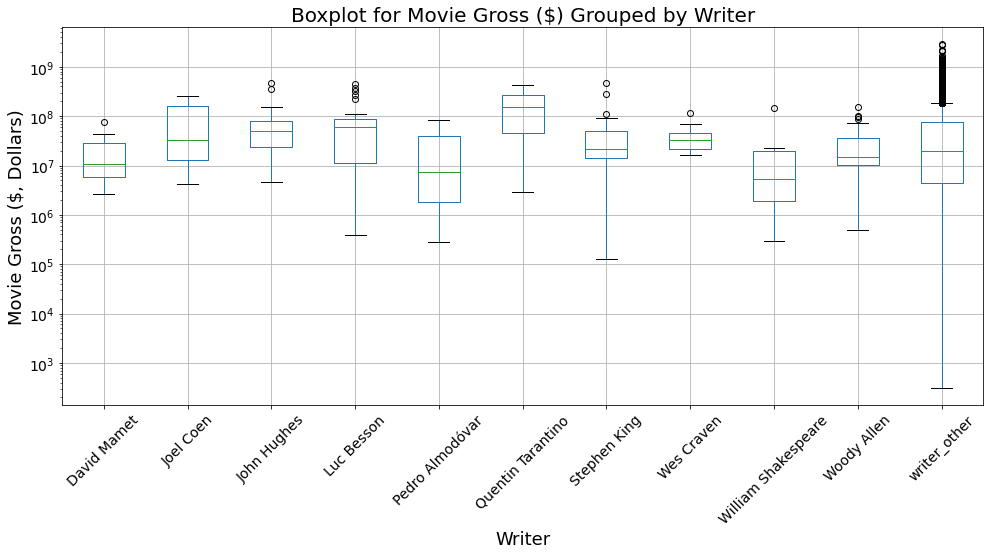

In [34]:
df[['writer','gross']].boxplot(by='writer', grid=True, figsize=(16,7))
plt.title('Boxplot for Movie Gross ($) Grouped by Writer', fontsize=20)
plt.suptitle('')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xticks(rotation=45)
plt.yscale('log')
plt.xlabel('Writer',fontsize = 18)
plt.ylabel('Movie Gross ($, Dollars)',fontsize = 18)
plt.savefig('../figures/Boxplot for Gross Grouped by Writer.png',dpi=300)
plt.show()

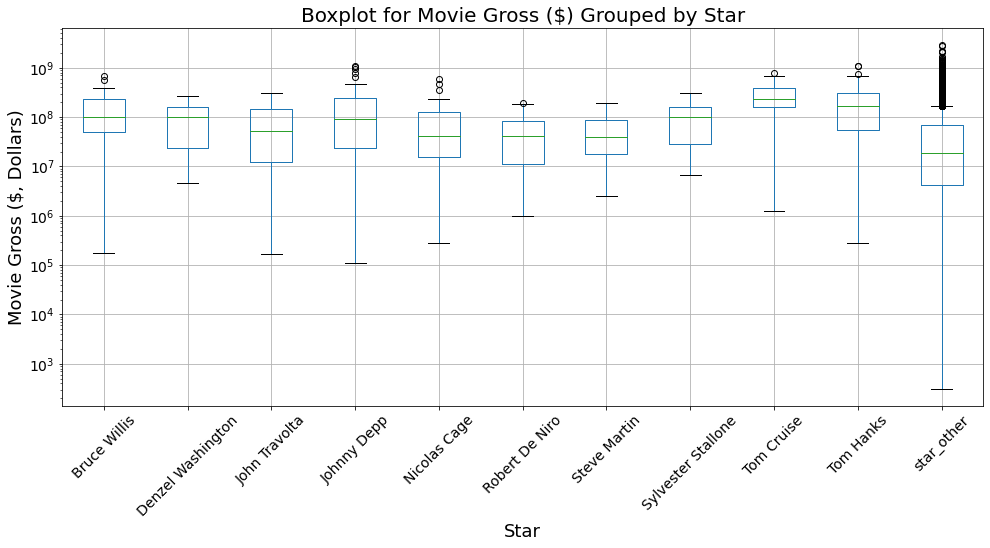

In [35]:
df[['star','gross']].boxplot(by='star', grid=True, figsize=(16,7))
plt.title('Boxplot for Movie Gross ($) Grouped by Star', fontsize=20)
plt.suptitle('')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xticks(rotation=45)
plt.yscale('log')
plt.xlabel('Star',fontsize = 18)
plt.ylabel('Movie Gross ($, Dollars)',fontsize = 18)
plt.savefig('../figures/Boxplot for Gross Grouped by Star.png',dpi=300)
plt.show()

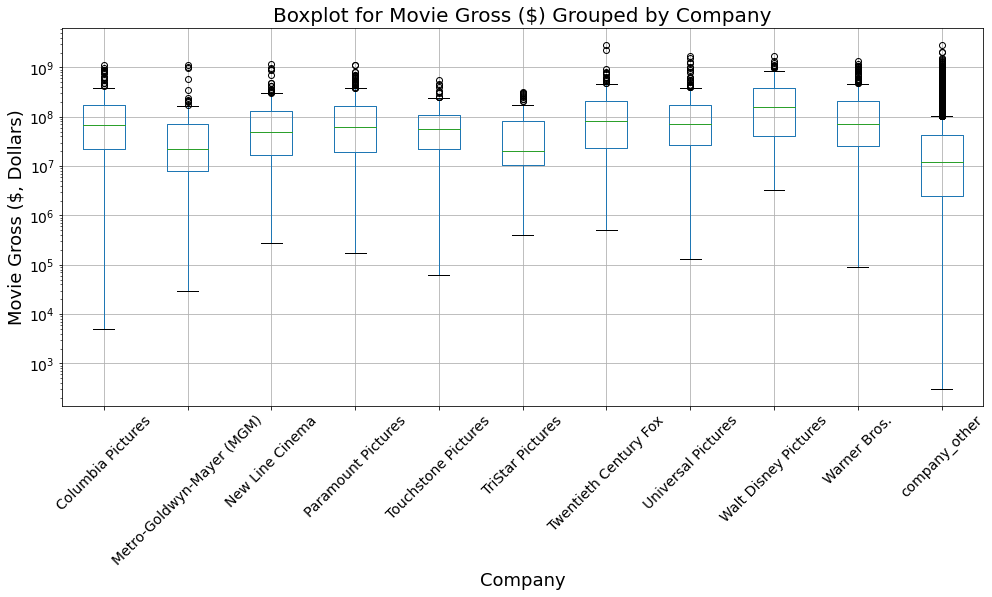

In [36]:
df[['company','gross']].boxplot(by='company', grid=True, figsize=(16,7))
plt.title('Boxplot for Movie Gross ($) Grouped by Company', fontsize=20)
plt.suptitle('')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xticks(rotation=45)
plt.yscale('log')
plt.xlabel('Company',fontsize = 18)
plt.ylabel('Movie Gross ($, Dollars)',fontsize = 18)
plt.savefig('../figures/Boxplot for Gross Grouped by Company.png',dpi=300)
plt.show()

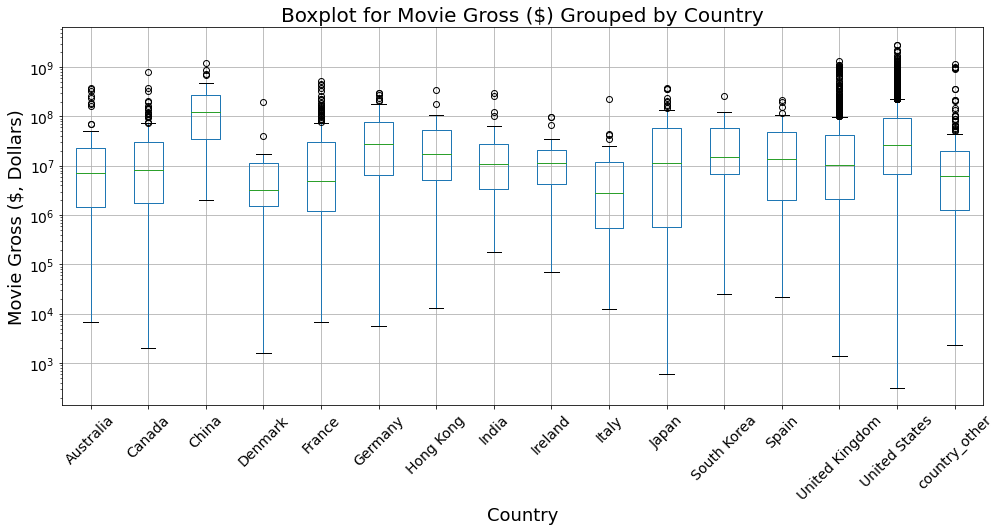

In [37]:
df[['country','gross']].boxplot(by='country', grid=True, figsize=(16,7))
plt.title('Boxplot for Movie Gross ($) Grouped by Country', fontsize=20)
plt.suptitle('')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xticks(rotation=45)
plt.yscale('log')
plt.xlabel('Country',fontsize = 18)
plt.ylabel('Movie Gross ($, Dollars)',fontsize = 18)
plt.savefig('../figures/Boxplot for Gross Grouped by Country.png',dpi=300)
plt.show()

In [38]:


#def alpha3code(column):
    #CODE=[]
   #for country in column:
        #try:
            #code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            #CODE.append(code)
        #except:
            #CODE.append('None')
    #return CODE
# create a column for code 
#df['CODE']=alpha3code(df.country)

In [39]:
# first let us merge geopandas data with our data
# 'naturalearth_lowres' is geopandas datasets so we can use it directly

#world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# rename the columns so that we can merge with our data

#world.columns=['pop_est', 'continent', 'name_country', 'CODE', 'gdp_md_est', 'geometry']
# then merge with our data 
#merge=pd.merge(world,df,on='CODE')
# last thing we need to do is - merge again with our location data which contains each country’s latitude and longitude



#location=pd.read_csv('https://raw.githubusercontent.com/melanieshi0120/COVID-19_global_time_series_panel_data/master/data/countries_latitude_longitude.csv')
#location.columns=['name_country', 'latitude', 'longitude']

#merge=merge.merge(location,how='left', on='name_country').sort_values(by='gross',ascending=False).reset_index()

In [40]:
# plot confirmed cases world map 
#merge.plot(column='gross', scheme="quantiles", k=20,
           #figsize=(25, 20),
           #legend=True,cmap='plasma')

# add countries names and numbers 
#for i in range(0,5):
    #plt.text(float(merge.longitude[i]),float(merge.latitude[i]),"{}\n{}".format(merge.name_country[i],merge.gross[i]),size=10)
#plt.show()

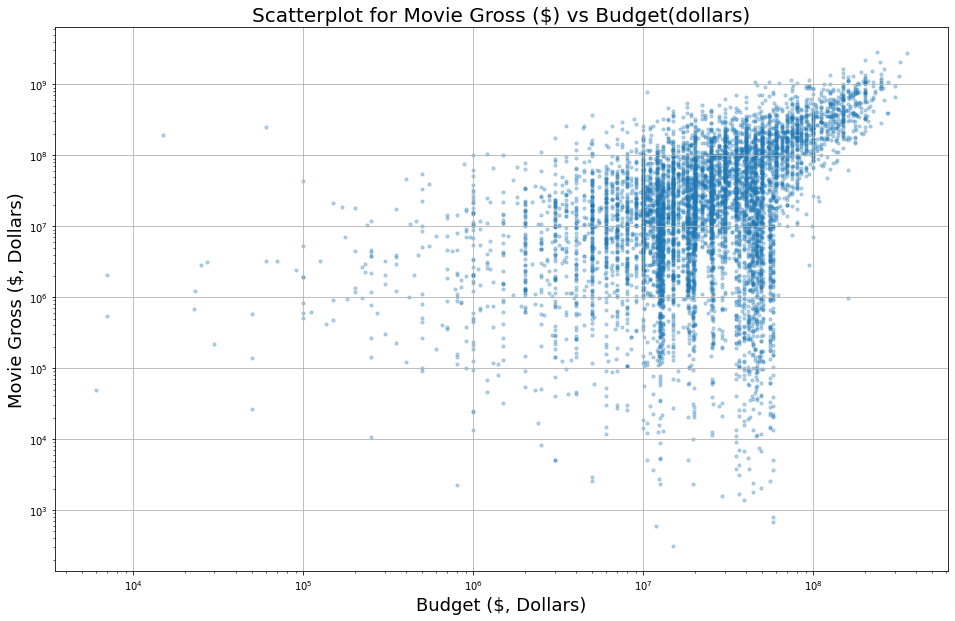

In [41]:
df.plot.scatter('budget', 'gross', alpha=0.3, s=10, grid=True, figsize=(16,10))
plt.title('Scatterplot for Movie Gross ($) vs Budget(dollars)', fontsize=20)
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Budget ($, Dollars)',fontsize = 18)
plt.ylabel('Movie Gross ($, Dollars)',fontsize = 18)
plt.savefig('../figures/Scatterplot for Gross vs Budget.png',dpi=300)
plt.show()


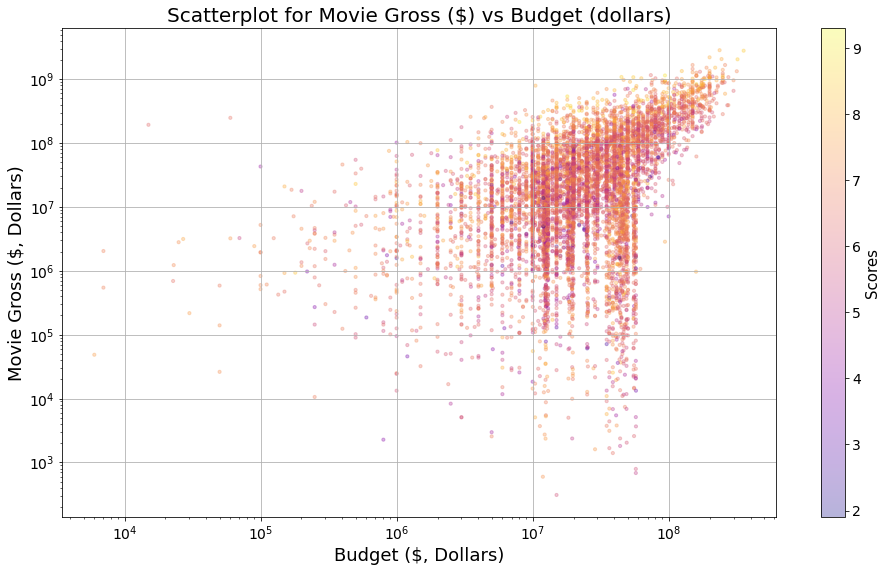

In [42]:
# Better plot for presentation using seaborn

plt.figure(figsize = (16,9))
plt.scatter(df.budget, df.gross, c=df.score, alpha=0.3, s=10, cmap="plasma")
plt.title('Scatterplot for Movie Gross ($) vs Budget (dollars)', fontsize=20)

cbar = plt.colorbar(label="Scores")
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('Scores',fontsize=15)

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)

plt.xlabel('Budget ($, Dollars)', fontsize=18)
plt.ylabel('Movie Gross ($, Dollars)', fontsize=18)
plt.grid(True)

plt.xscale('log')
plt.yscale('log')

plt.savefig('../figures/Scatterplot for Gross vs Budget_present.png',dpi=300)
plt.show()

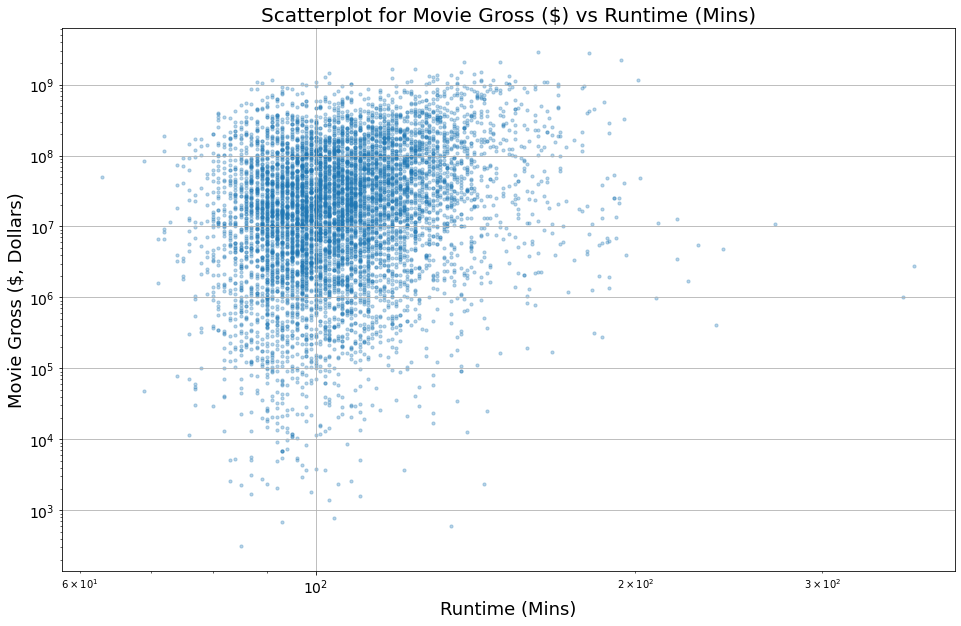

In [43]:

df.plot.scatter('runtime', 'gross', alpha=0.3, s=10, grid=True, figsize=(16,10))
plt.title('Scatterplot for Movie Gross ($) vs Runtime (Mins)', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xlabel('Runtime (Mins)', fontsize=18)
plt.ylabel('Movie Gross ($, Dollars)', fontsize=18)
plt.savefig('../figures/Scatterplot for Gross vs Runtime.png',dpi=300)
plt.show()


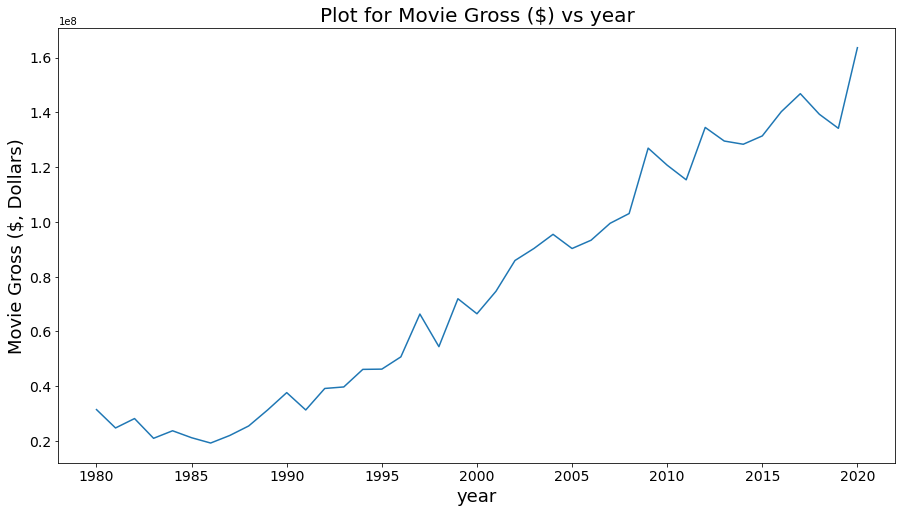

In [44]:
plt.figure(figsize=(15,8))
yearly=df.groupby(df['released_year'])['gross'].agg('mean')
plt.plot(yearly.index,yearly)
plt.title('Plot for Movie Gross ($) vs year', fontsize=20)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xlabel('year', fontsize=18)
plt.ylabel("Movie Gross ($, Dollars)", fontsize=18)
plt.savefig('../figures/Plot for Gross vs year.png',dpi=300)
plt.show()


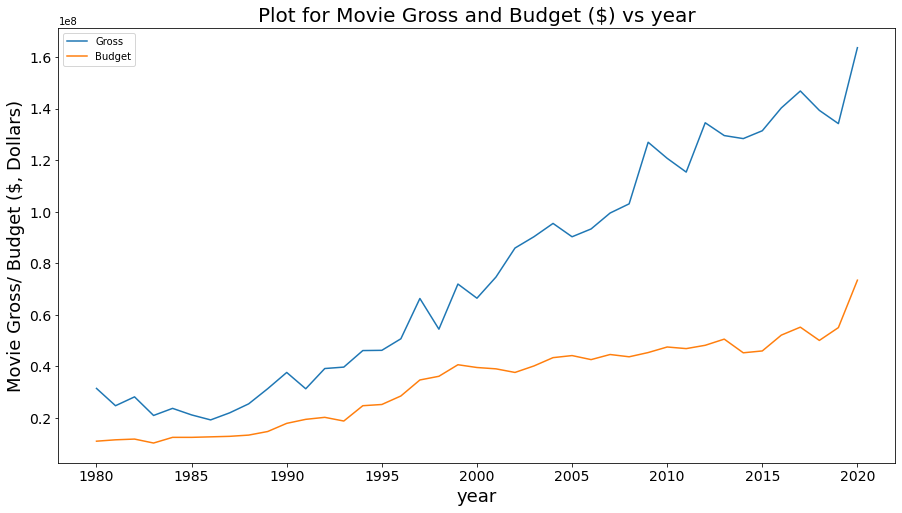

In [45]:
# Better plot for presentation using seaborn
plt.figure(figsize=(15,8))
yearly=df.groupby(df['released_year'])['gross'].agg('mean')
plt.plot(yearly.index,yearly)
yearly_bu=df.groupby(df['released_year'])['budget'].agg('mean')
plt.plot(yearly_bu.index,yearly_bu)
plt.legend(['Gross','Budget'])
plt.title('Plot for Movie Gross and Budget ($) vs year', fontsize=20)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xlabel('year', fontsize=18)
plt.ylabel("Movie Gross/ Budget ($, Dollars)", fontsize=18)
plt.savefig('../figures/Plot for Gross and Budget vs year_present.png',dpi=300)
plt.show()

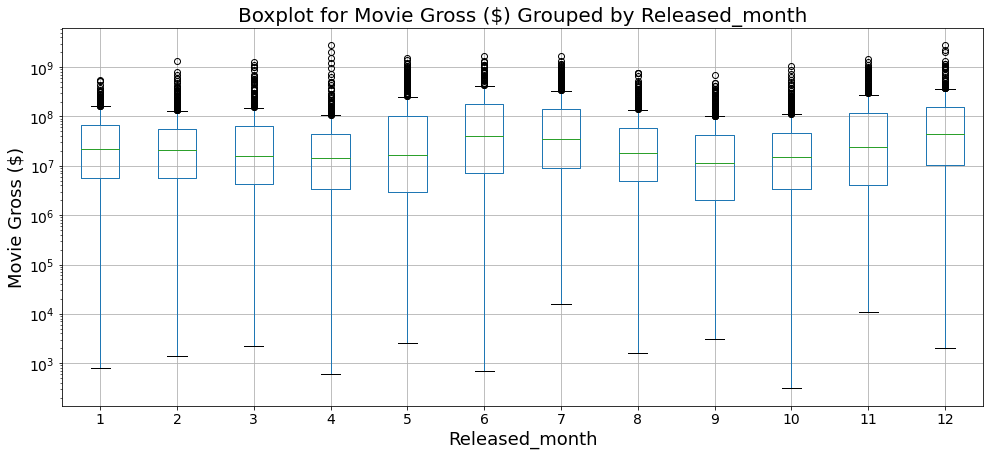

In [46]:
df[['released_month','gross']].boxplot(by='released_month', grid=True, figsize=(16,7))
plt.title('Boxplot for Movie Gross ($) Grouped by Released_month', fontsize=20)
plt.suptitle('')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.yscale('log')
plt.xlabel('Released_month', fontsize=18)
plt.ylabel('Movie Gross ($)', fontsize=18)
plt.savefig('../figures/Boxplot for Gross Grouped by Released_month.png',dpi=300)
plt.show()

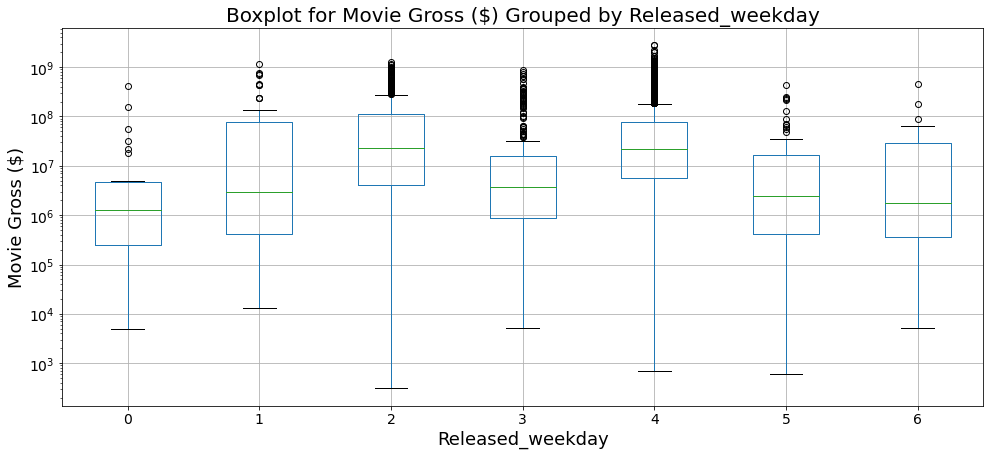

In [47]:
df[['released_weekday','gross']].boxplot(by='released_weekday', grid=True, figsize=(16,7))
plt.title('Boxplot for Movie Gross ($) Grouped by Released_weekday', fontsize=20)
plt.suptitle('')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.yscale('log')
plt.xlabel('Released_weekday', fontsize=18)
plt.ylabel('Movie Gross ($)', fontsize=18)
plt.savefig('../figures/Boxplot for Gross Grouped by Released_weekday.png',dpi=300)
plt.show()

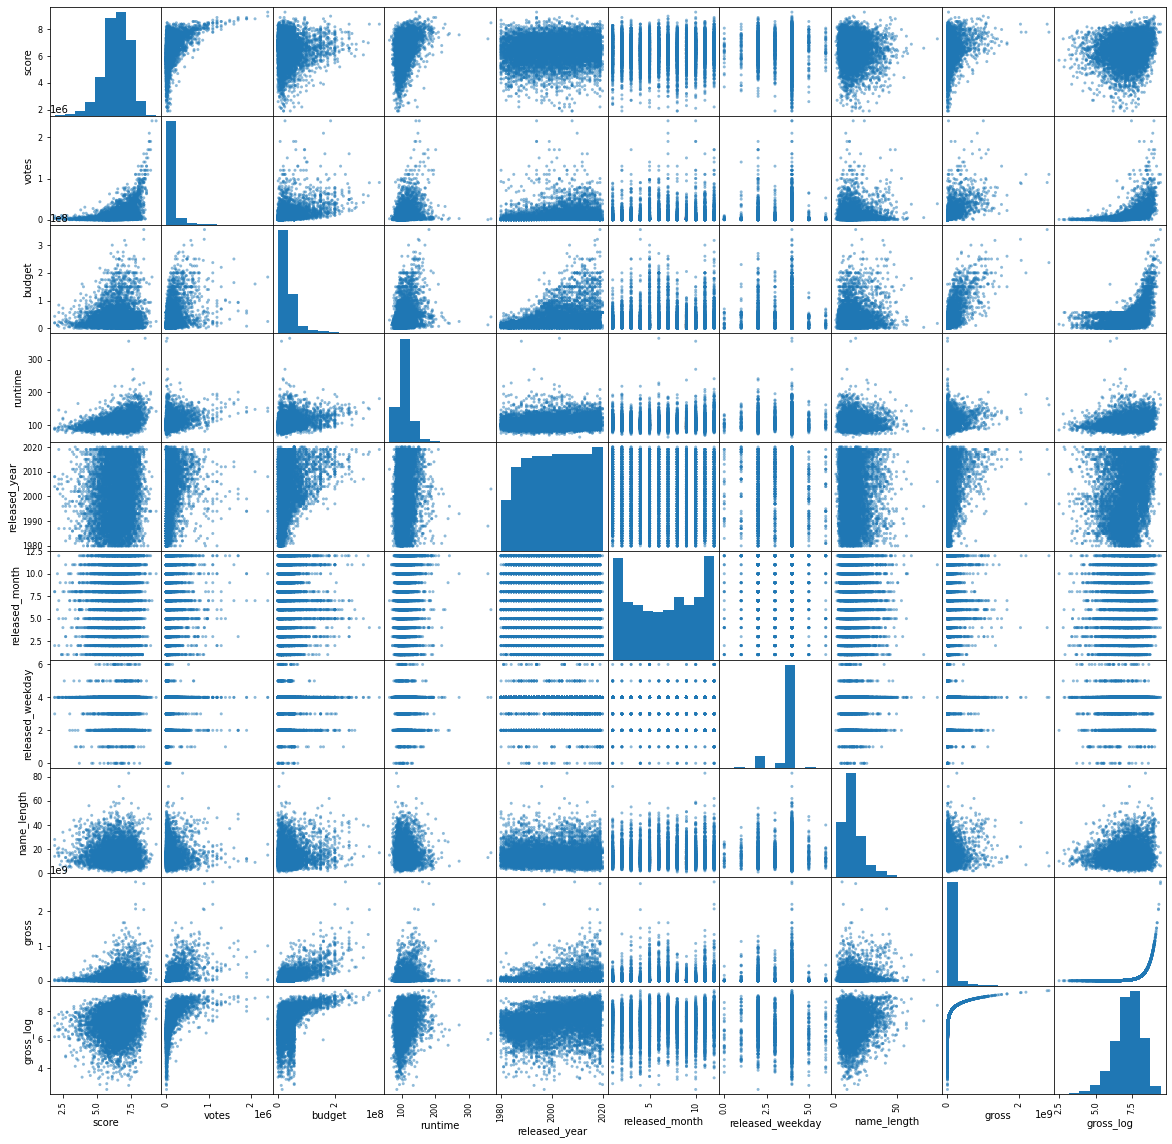

In [48]:
pd.plotting.scatter_matrix(df.iloc[:,0:18], figsize=(20, 20), alpha=0.5,range_padding = 0.1)
plt.savefig('../figures/Scatter matrix.png',dpi=300)
plt.show()

In [49]:
df = df.drop(columns=['name', 'gross_log'])
df

,rating,genre,score,votes,director,writer,star,country,budget,company,runtime,released_year,released_month,released_weekday,name_length,gross
0,R,Drama,8.4,927000.0,director_other,Stephen King,star_other,United Kingdom,19000000.0,Warner Bros.,146.0,1980,6,4,11,46998772.0
1,R,Adventure,5.8,65000.0,director_other,writer_other,star_other,United States,4500000.0,Columbia Pictures,104.0,1980,7,2,15,58853106.0
2,PG,Action,8.7,1200000.0,director_other,writer_other,star_other,United States,18000000.0,company_other,124.0,1980,6,4,46,538375067.0
3,PG,Comedy,7.7,221000.0,director_other,writer_other,star_other,United States,3500000.0,Paramount Pictures,88.0,1980,7,2,9,83453539.0
4,R,Comedy,7.3,108000.0,director_other,writer_other,star_other,United States,6000000.0,company_other,98.0,1980,7,4,10,39846344.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7653,R,Crime,5.4,2400.0,director_other,writer_other,star_other,United States,57530000.0,company_other,98.0,2020,4,4,10,3661.0
7655,TV-PG,Animation,6.6,1300.0,director_other,NaN,star_other,China,57530000.0,company_other,110.0,2020,10,3,21,240663149.0
7656,PG-13,Comedy,5.0,294.0,director_other,writer_other,star_other,United States,57530000.0,company_other,120.0,2020,6,2,5,413378.0
7657,NaN,Drama,6.7,903.0,director_other,writer_other,star_other,China,57530000.0,NaN,135.0,2020,9,4,4,25818882.0


### 2.0 Split the data into different sets:

In [50]:
df.isna().sum()

rating              360
genre                 0
score                 0
votes                 0
director              0
writer                3
star                  0
country               1
budget                0
company              10
runtime               1
released_year         0
released_month        0
released_weekday      0
name_length           0
gross                 0
dtype: int64

In [51]:
# drop the row with runtime = nan
df = df[df['runtime'].notna()]

In [52]:
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(df.isnull().sum(axis=1)!=0)/df.shape[0]
print('fraction of points with missing values:',frac_missing)

fraction of missing values in features:
rating     0.048141
writer     0.000401
country    0.000134
company    0.001337
dtype: float64
data types of the features with missing values:
rating     object
writer     object
country    object
company    object
dtype: object
fraction of points with missing values: 0.0493447445841134


In [53]:
y = df['gross'] # remember, we want to predict who earns more than 50k or less than 50k
X = df.loc[:, df.columns != 'gross'] # all other columns are features

In [54]:
df.head(5)

,rating,genre,score,votes,director,writer,star,country,budget,company,runtime,released_year,released_month,released_weekday,name_length,gross
0,R,Drama,8.4,927000.0,director_other,Stephen King,star_other,United Kingdom,19000000.0,Warner Bros.,146.0,1980,6,4,11,46998772.0
1,R,Adventure,5.8,65000.0,director_other,writer_other,star_other,United States,4500000.0,Columbia Pictures,104.0,1980,7,2,15,58853106.0
2,PG,Action,8.7,1200000.0,director_other,writer_other,star_other,United States,18000000.0,company_other,124.0,1980,6,4,46,538375067.0
3,PG,Comedy,7.7,221000.0,director_other,writer_other,star_other,United States,3500000.0,Paramount Pictures,88.0,1980,7,2,9,83453539.0
4,R,Comedy,7.3,108000.0,director_other,writer_other,star_other,United States,6000000.0,company_other,98.0,1980,7,4,10,39846344.0


In [55]:
df.to_csv('../data/clean_movies.csv')

### 3.0 Preprocess the data:

In [56]:
# collect which encoder to use on each feature
# needs to be done manually

onehot_ftrs = ['rating','genre','director','writer','star','country', 'company', 'released_year','released_month','released_weekday']
minmax_ftrs = ['score','runtime']
std_ftrs = ['votes', 'budget', 'name_length']

# one-hot encoder
# We need to replace the NaN with a string first!
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])


# standard scaler
std_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# minmax scaler
minmax_transformer = Pipeline(steps=[
    ('minmax', MinMaxScaler())])


# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, onehot_ftrs),
        ('std', std_transformer, std_ftrs),
        ('minmax', minmax_transformer, minmax_ftrs)])

In [57]:

random_state = 42
clf = Pipeline(steps=[('preprocessor', preprocessor)])

X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=random_state)

# first split to separate out the training set
X_train, X_val, y_train, y_val = train_test_split(X_other,y_other,train_size = 0.8,random_state=random_state)

# make into row vectors to avoid an obnoxious sklearn/xgb warning
#y_train = np.reshape(np.array(y_train), (1, -1)).ravel()
#y_val = np.reshape(np.array(y_val), (1, -1)).ravel()
#y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

# use pipeline to preprocess the datasets
X_train = clf.fit_transform(X_train)
X_val = clf.transform(X_val)
X_test = clf.transform(X_test)


In [58]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(4785, 154)
(1197, 154)
(1496, 154)


In [59]:
def MLpipe_KFold_RMSE(X, y, preprocessor, ML_algo, param_grid):
    '''
    This function splits the data to other/test (80/20) and then applies KFold with 4 folds to other.
    The RMSE is minimized in cross-validation.
    '''
    
    n_states = 10
    n_best_models = []
    n_rmse = np.zeros(n_states)
    
    for i in range(n_states):
        X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=42*i)
    
        kf = KFold(n_splits=5,shuffle=True,random_state=42*i)
        
        pipe = make_pipeline(preprocessor, ML_algo)

        grid = GridSearchCV(pipe, param_grid=param_grid, scoring = 'neg_root_mean_squared_error', cv=kf, return_train_score = True, n_jobs=-1, verbose=True)
    
        grid.fit(X_other, y_other)
        
        n_best_models.append(grid)

        y_test_pred = n_best_models[-1].predict(X_test)
        
        n_rmse[i] = np.sqrt(mean_squared_error(y_test,y_test_pred))
        print('best model parameters:',grid.best_params_)
        print('rmse score:',n_rmse[i])
    
    return n_best_models, n_rmse

In [60]:
def baseline_RMSE(X, y):
    n_states = 10
    all_baseline_rmse = np.zeros(n_states)
    for i in range(n_states):
        X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=42*i)
        
        y_test_baseline = np.full(y_test.shape, np.mean(y_train))
        all_baseline_rmse[i] = np.sqrt(mean_squared_error(y_test,y_test_baseline))
    
    return all_baseline_rmse

baseline_rmse = baseline_RMSE(X, y)

**RIDGE**

In [61]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge()
param_grid_ridge = {
              'ridge__alpha': np.logspace(-10,3,51), # the max_depth should be smaller or equal than the number of features roughly
              'ridge__max_iter': [100000000] # linearly spaced between 0.5 and 1
              } 

ridge_model, ridge_rmse = MLpipe_KFold_RMSE(X, y, preprocessor, ridge_reg, param_grid_ridge)

Fitting 5 folds for each of 51 candidates, totalling 255 fits
best model parameters: {'ridge__alpha': 8.317637711026709, 'ridge__max_iter': 100000000}
rmse score: 96340179.73809299
Fitting 5 folds for each of 51 candidates, totalling 255 fits
best model parameters: {'ridge__alpha': 27.542287033381747, 'ridge__max_iter': 100000000}
rmse score: 106761845.36371744
Fitting 5 folds for each of 51 candidates, totalling 255 fits
best model parameters: {'ridge__alpha': 15.135612484362072, 'ridge__max_iter': 100000000}
rmse score: 103239837.25434166
Fitting 5 folds for each of 51 candidates, totalling 255 fits
best model parameters: {'ridge__alpha': 15.135612484362072, 'ridge__max_iter': 100000000}
rmse score: 89032351.37927069
Fitting 5 folds for each of 51 candidates, totalling 255 fits
best model parameters: {'ridge__alpha': 15.135612484362072, 'ridge__max_iter': 100000000}
rmse score: 80832114.51431054
Fitting 5 folds for each of 51 candidates, totalling 255 fits
best model parameters: {'ri

**RF**

In [62]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()

param_grid_rf = {
              'randomforestregressor__max_depth': [1, 10, 20, 40, 60, 100, 140, 150], # the max_depth should be smaller or equal than the number of features roughly
              'randomforestregressor__max_features': [0.2,0.4,0.5,0.6,0.8,1.0]  # linearly spaced between 0.5 and 1
              } 

rf_model, rf_rmse = MLpipe_KFold_RMSE(X, y, preprocessor, rf_reg, param_grid_rf)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
best model parameters: {'randomforestregressor__max_depth': 60, 'randomforestregressor__max_features': 0.4}
rmse score: 82164291.69044203
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best model parameters: {'randomforestregressor__max_depth': 150, 'randomforestregressor__max_features': 0.4}
rmse score: 88188072.19728404
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best model parameters: {'randomforestregressor__max_depth': 60, 'randomforestregressor__max_features': 0.4}
rmse score: 89689146.04745333
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best model parameters: {'randomforestregressor__max_depth': 150, 'randomforestregressor__max_features': 0.5}
rmse score: 76572226.42041786
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best model parameters: {'randomforestregressor__max_depth': 40, 'randomforestregressor__max_features': 0.5}
rmse score: 68958590.6287074

**SVR**

**KNN**

In [63]:
from sklearn.neighbors import KNeighborsRegressor

knr_reg = KNeighborsRegressor()

param_grid_knr = {
              'kneighborsregressor__p': [1, 3, 10],
              'kneighborsregressor__n_neighbors': [1, 3, 10, 20, 50, 100]              

}


knr_model, knr_rmse = MLpipe_KFold_RMSE(X, y, preprocessor, knr_reg, param_grid_knr)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
best model parameters: {'kneighborsregressor__n_neighbors': 3, 'kneighborsregressor__p': 1}
rmse score: 96111260.73909502
Fitting 5 folds for each of 18 candidates, totalling 90 fits
best model parameters: {'kneighborsregressor__n_neighbors': 20, 'kneighborsregressor__p': 3}
rmse score: 105249690.37787643
Fitting 5 folds for each of 18 candidates, totalling 90 fits
best model parameters: {'kneighborsregressor__n_neighbors': 10, 'kneighborsregressor__p': 1}
rmse score: 100513536.33950219
Fitting 5 folds for each of 18 candidates, totalling 90 fits
best model parameters: {'kneighborsregressor__n_neighbors': 10, 'kneighborsregressor__p': 10}
rmse score: 85764691.42291398
Fitting 5 folds for each of 18 candidates, totalling 90 fits
best model parameters: {'kneighborsregressor__n_neighbors': 10, 'kneighborsregressor__p': 1}
rmse score: 78099684.85701892
Fitting 5 folds for each of 18 candidates, totalling 90 fits
best model parame

**XGBoost**

In [64]:
XGB = xgboost.XGBRegressor()

param_grid_xgb = {"xgbregressor__learning_rate": [0.03],
                  "xgbregressor__seed": [0],
                  #"reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  #"reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  "xgbregressor__missing": [np.nan], 
                  "xgbregressor__max_depth": [1,2,6],
                  "xgbregressor__colsample_bytree": [0.9],              
                  "xgbregressor__subsample": [0.66]}


xgb_model, xgb_rmse = MLpipe_KFold_RMSE(X, y, preprocessor, XGB, param_grid_xgb)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
best model parameters: {'xgbregressor__colsample_bytree': 0.9, 'xgbregressor__learning_rate': 0.03, 'xgbregressor__max_depth': 6, 'xgbregressor__missing': nan, 'xgbregressor__seed': 0, 'xgbregressor__subsample': 0.66}
rmse score: 81192620.2719663
Fitting 5 folds for each of 3 candidates, totalling 15 fits
best model parameters: {'xgbregressor__colsample_bytree': 0.9, 'xgbregressor__learning_rate': 0.03, 'xgbregressor__max_depth': 6, 'xgbregressor__missing': nan, 'xgbregressor__seed': 0, 'xgbregressor__subsample': 0.66}
rmse score: 87632927.96729463
Fitting 5 folds for each of 3 candidates, totalling 15 fits
best model parameters: {'xgbregressor__colsample_bytree': 0.9, 'xgbregressor__learning_rate': 0.03, 'xgbregressor__max_depth': 6, 'xgbregressor__missing': nan, 'xgbregressor__seed': 0, 'xgbregressor__subsample': 0.66}
rmse score: 91856000.90149233
Fitting 5 folds for each of 3 candidates, totalling 15 fits
best model parame

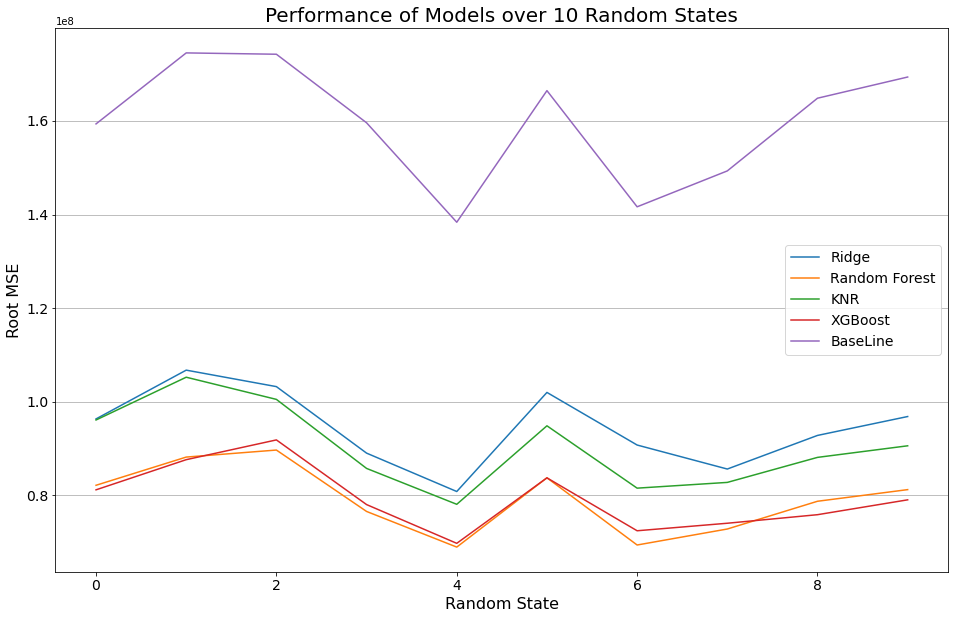

In [65]:
import matplotlib.pyplot as plt

f = plt.figure()
f.set_figwidth(16)
f.set_figheight(10)
plt.plot(ridge_rmse, label="Ridge")
plt.plot(rf_rmse, label="Random Forest")
plt.plot(knr_rmse, label="KNR")
plt.plot(xgb_rmse, label="XGBoost")
plt.plot(baseline_rmse, label="BaseLine")
baseline_rmse
plt.grid(axis='y')
plt.xlabel("Random State", fontsize = 16)
plt.ylabel("Root MSE", fontsize = 16)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.title("Performance of Models over 10 Random States", fontsize=20)
plt.legend(fontsize=14)


plt.savefig('../figures/models_by_rmse.png', dpi=300)
plt.show()

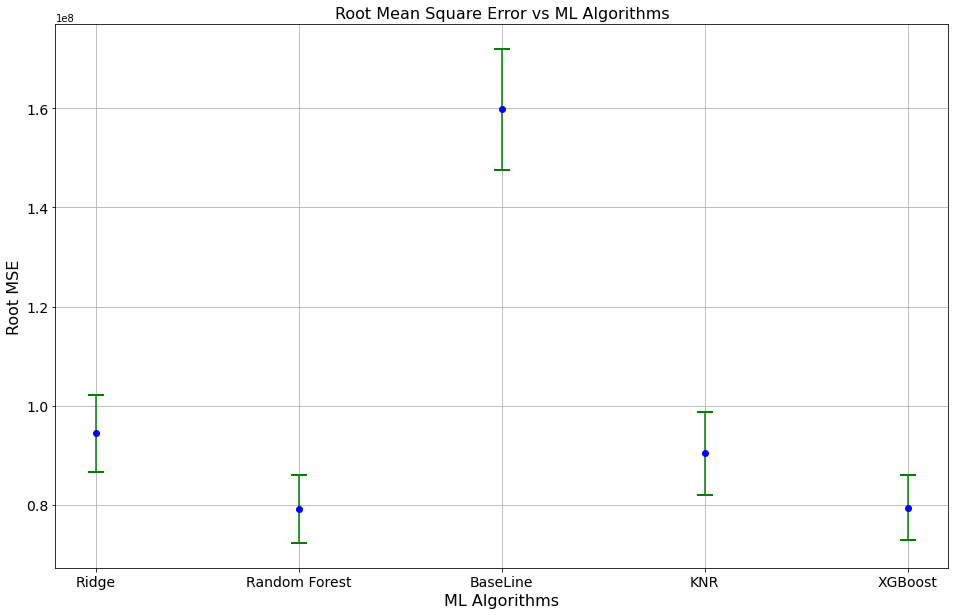

In [66]:
from statistics import mean, stdev





mean_rmse = [np.mean(ridge_rmse),np.mean(rf_rmse),np.mean(baseline_rmse),np.mean(knr_rmse),np.mean(xgb_rmse)]
std_rmse = [np.std(ridge_rmse),np.std(rf_rmse),np.std(baseline_rmse),np.std(knr_rmse),np.std(xgb_rmse)]
labels = ["Ridge", "Random Forest", "BaseLine", "KNR", "XGBoost"]

plt.figure(figsize=(16,10))
plt.errorbar(np.arange(5), mean_rmse, yerr=std_rmse, fmt='o', ecolor='g', color = 'b',capthick=2,capsize=8)
plt.grid()
plt.xticks(np.arange(5), labels)
plt.xlabel('ML Algorithms', fontsize = 16)
plt.ylabel('Root MSE', fontsize = 16)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.title('Root Mean Square Error vs ML Algorithms', fontsize = 16)




plt.savefig('../figures/RMSE_by_model.png', dpi=300, format='png')
plt.show()

In [67]:
from sklearn.metrics import r2_score
def MLpipe_KFold_R2(X, y, preprocessor, ML_algo, param_grid):
    '''
    This function splits the data to other/test (80/20) and then applies KFold with 4 folds to other.
    The R2 is minimized in cross-validation.
    '''
    
    n_states = 10
    n_best_models = []
    n_r2 = np.zeros(n_states)
    
    for i in range(n_states):
        X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=42*i)
    
        kf = KFold(n_splits=5,shuffle=True,random_state=42*i)
        
        pipe = make_pipeline(preprocessor, ML_algo)

        grid = GridSearchCV(pipe, param_grid=param_grid, scoring = 'r2', cv=kf, return_train_score = True, n_jobs=-1, verbose=True)
    
        grid.fit(X_other, y_other)
        
        n_best_models.append(grid)

        y_test_pred = n_best_models[-1].predict(X_test)
        
        n_r2[i] = r2_score(y_test,y_test_pred)
        print('best model parameters:',grid.best_params_)
        print('r2 score:',n_r2[i])
    
    return n_best_models, n_r2

In [68]:
#ridge
from sklearn.linear_model import Ridge
ridge_reg = Ridge()
param_grid_ridge = {
              'ridge__alpha': np.logspace(-10,3,51), # the max_depth should be smaller or equal than the number of features roughly
              'ridge__max_iter': [100000000] # linearly spaced between 0.5 and 1
              } 

ridge_model_r2, ridge_r2 = MLpipe_KFold_R2(X, y, preprocessor, ridge_reg, param_grid_ridge)

Fitting 5 folds for each of 51 candidates, totalling 255 fits
best model parameters: {'ridge__alpha': 8.317637711026709, 'ridge__max_iter': 100000000}
r2 score: 0.6344629245594835
Fitting 5 folds for each of 51 candidates, totalling 255 fits
best model parameters: {'ridge__alpha': 27.542287033381747, 'ridge__max_iter': 100000000}
r2 score: 0.6255086593242092
Fitting 5 folds for each of 51 candidates, totalling 255 fits
best model parameters: {'ridge__alpha': 15.135612484362072, 'ridge__max_iter': 100000000}
r2 score: 0.6489503354763952
Fitting 5 folds for each of 51 candidates, totalling 255 fits
best model parameters: {'ridge__alpha': 15.135612484362072, 'ridge__max_iter': 100000000}
r2 score: 0.6888114054137939
Fitting 5 folds for each of 51 candidates, totalling 255 fits
best model parameters: {'ridge__alpha': 8.317637711026709, 'ridge__max_iter': 100000000}
r2 score: 0.655618891914149
Fitting 5 folds for each of 51 candidates, totalling 255 fits
best model parameters: {'ridge__alph

In [69]:
#RF
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()

param_grid_rf = {
              'randomforestregressor__max_depth': [1, 10, 20, 40, 60, 100, 140, 150], # the max_depth should be smaller or equal than the number of features roughly
              'randomforestregressor__max_features': [0.2,0.4,0.5,0.6,0.8,1.0]  # linearly spaced between 0.5 and 1
              } 

rf_model_r2, rf_r2 = MLpipe_KFold_R2(X, y, preprocessor, rf_reg, param_grid_rf)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
best model parameters: {'randomforestregressor__max_depth': 140, 'randomforestregressor__max_features': 0.4}
r2 score: 0.7357085381584197
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best model parameters: {'randomforestregressor__max_depth': 140, 'randomforestregressor__max_features': 0.4}
r2 score: 0.7518520331366532
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best model parameters: {'randomforestregressor__max_depth': 20, 'randomforestregressor__max_features': 0.4}
r2 score: 0.727328382990541
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best model parameters: {'randomforestregressor__max_depth': 20, 'randomforestregressor__max_features': 0.5}
r2 score: 0.7782391036400341
Fitting 5 folds for each of 48 candidates, totalling 240 fits
best model parameters: {'randomforestregressor__max_depth': 100, 'randomforestregressor__max_features': 0.4}
r2 score: 0.7542347354002001
Fit

In [70]:
#SVR
from sklearn.svm import SVR

svr_reg = SVR()

param_grid_svr = {
              'svr__gamma': [0.001, 0.01, 0.1, 1, 10],
              'svr__C': [1, 1e1, 1e3, 1e5]
              }


svr_model_r2, svr_r2 = MLpipe_KFold_R2(X, y, preprocessor, svr_reg, param_grid_svr)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
best model parameters: {'svr__C': 100000.0, 'svr__gamma': 0.1}
r2 score: -0.035860855165020356
Fitting 5 folds for each of 20 candidates, totalling 100 fits
best model parameters: {'svr__C': 100000.0, 'svr__gamma': 0.1}
r2 score: -0.022660624981736266
Fitting 5 folds for each of 20 candidates, totalling 100 fits
best model parameters: {'svr__C': 100000.0, 'svr__gamma': 0.1}
r2 score: -0.03817551566711397
Fitting 5 folds for each of 20 candidates, totalling 100 fits
best model parameters: {'svr__C': 100000.0, 'svr__gamma': 0.1}
r2 score: -0.04106459359052472
Fitting 5 folds for each of 20 candidates, totalling 100 fits
best model parameters: {'svr__C': 100000.0, 'svr__gamma': 0.1}
r2 score: -0.015539416049822119
Fitting 5 folds for each of 20 candidates, totalling 100 fits
best model parameters: {'svr__C': 100000.0, 'svr__gamma': 0.1}
r2 score: -0.03212487253307672
Fitting 5 folds for each of 20 candidates, totalling 100 fits

In [71]:
#KNNR
from sklearn.neighbors import KNeighborsRegressor

knr_reg = KNeighborsRegressor()

param_grid_knr = {
              'kneighborsregressor__p': [1, 3, 10],
              'kneighborsregressor__n_neighbors': [1, 3, 10, 20, 50, 100]              

}


knr_model_r2, knr_r2 = MLpipe_KFold_R2(X, y, preprocessor, knr_reg, param_grid_knr)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
best model parameters: {'kneighborsregressor__n_neighbors': 10, 'kneighborsregressor__p': 3}
r2 score: 0.6586668063724865
Fitting 5 folds for each of 18 candidates, totalling 90 fits
best model parameters: {'kneighborsregressor__n_neighbors': 20, 'kneighborsregressor__p': 3}
r2 score: 0.6360419831011165
Fitting 5 folds for each of 18 candidates, totalling 90 fits
best model parameters: {'kneighborsregressor__n_neighbors': 10, 'kneighborsregressor__p': 1}
r2 score: 0.6672461832141936
Fitting 5 folds for each of 18 candidates, totalling 90 fits
best model parameters: {'kneighborsregressor__n_neighbors': 10, 'kneighborsregressor__p': 3}
r2 score: 0.7039800348614608
Fitting 5 folds for each of 18 candidates, totalling 90 fits
best model parameters: {'kneighborsregressor__n_neighbors': 10, 'kneighborsregressor__p': 1}
r2 score: 0.6792158061339554
Fitting 5 folds for each of 18 candidates, totalling 90 fits
best model parameters: {

In [72]:
#XGB
XGB = xgboost.XGBRegressor()

param_grid_xgb = {"xgbregressor__learning_rate": [0.03],
                  "xgbregressor__seed": [0],
                  #"reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  #"reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  "xgbregressor__missing": [np.nan], 
                  "xgbregressor__max_depth": [1,2,6],
                  "xgbregressor__colsample_bytree": [0.9],              
                  "xgbregressor__subsample": [0.66]}


xgb_model_r2, xgb_r2 = MLpipe_KFold_R2(X, y, preprocessor, XGB, param_grid_xgb)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
best model parameters: {'xgbregressor__colsample_bytree': 0.9, 'xgbregressor__learning_rate': 0.03, 'xgbregressor__max_depth': 6, 'xgbregressor__missing': nan, 'xgbregressor__seed': 0, 'xgbregressor__subsample': 0.66}
r2 score: 0.7403731267759277
Fitting 5 folds for each of 3 candidates, totalling 15 fits
best model parameters: {'xgbregressor__colsample_bytree': 0.9, 'xgbregressor__learning_rate': 0.03, 'xgbregressor__max_depth': 6, 'xgbregressor__missing': nan, 'xgbregressor__seed': 0, 'xgbregressor__subsample': 0.66}
r2 score: 0.7476842962863025
Fitting 5 folds for each of 3 candidates, totalling 15 fits
best model parameters: {'xgbregressor__colsample_bytree': 0.9, 'xgbregressor__learning_rate': 0.03, 'xgbregressor__max_depth': 6, 'xgbregressor__missing': nan, 'xgbregressor__seed': 0, 'xgbregressor__subsample': 0.66}
r2 score: 0.7220997052531299
Fitting 5 folds for each of 3 candidates, totalling 15 fits
best model paramete

Text(0.5, 1.0, 'R2 Score vs ML Algorithms')

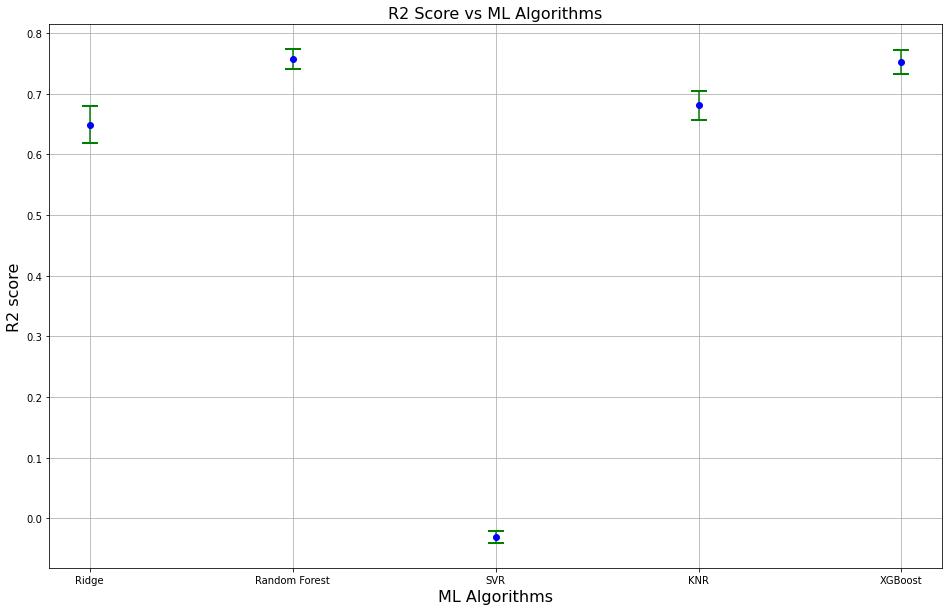

In [73]:
from statistics import mean, stdev

mean_r2 = [np.mean(ridge_r2),np.mean(rf_r2),np.mean(svr_r2),np.mean(knr_r2),np.mean(xgb_r2)]
std_r2 = [np.std(ridge_r2),np.std(rf_r2),np.std(svr_r2),np.std(knr_r2),np.std(xgb_r2)]
labels = ["Ridge", "Random Forest", "SVR", "KNR", "XGBoost"]

plt.figure(figsize=(16,10))
plt.errorbar(np.arange(5), mean_r2, yerr=std_r2, fmt='o', ecolor='g', color = 'b',capthick=2,capsize=8)
plt.grid()
plt.xticks(np.arange(5), labels)
plt.xlabel('ML Algorithms', fontsize = 16)
plt.ylabel('R2 score', fontsize = 16)
plt.title('R2 Score vs ML Algorithms', fontsize = 16)

In [74]:
file = open('../results/ridge_models_tuned.save', 'wb')
pickle.dump(ridge_model, file)
file.close()

file = open('../results/rf_models_tuned.save', 'wb')
pickle.dump(rf_model, file)
file.close()

file = open('../results/knr_models_tuned.save', 'wb')
pickle.dump(knr_model, file)
file.close()

file = open('../results/xgb_models_tuned.save', 'wb')
pickle.dump(xgb_model, file)
file.close()